In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

In [2]:
tf.__version__

'1.15.3'

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [6]:
ds, meta = tfds.load('malaria', with_info=True)

    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4


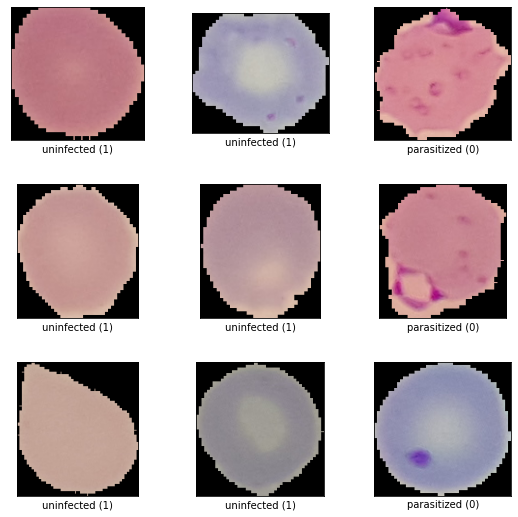

In [7]:
fig = tfds.show_examples(ds['train'], meta)

In [8]:
(train_data, valid_data, test_data), meta = tfds.load('malaria', split=['train[:60%]', 'train[60%:80%]', 'train[80%:]'], with_info=True, as_supervised=True)

    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})> could not be transformed and will be executed as-is. Please report this to the AutoGr

In [9]:
print(meta.description)

The Malaria dataset contains a total of 27,558 cell images
with equal instances of parasitized and uninfected cells from the thin blood 
smear slide images of segmented cells.


In [10]:
import math

num_train = meta.splits['train[:60%]'].num_examples
num_valid = meta.splits['train[60%:80%]'].num_examples
num_test  = meta.splits['train[80%:]'].num_examples

print(num_train)
print(num_valid)
print(num_test)

16535
5511
5512


In [11]:
def preprocess(images, labels):
    images = tf.cast(images, tf.float32)
    images = tf.image.resize(images, (224, 224))
    images /= 255.0
    return images, labels

train_data = train_data.map(preprocess).cache().shuffle(42).batch(32).repeat().prefetch(1)
valid_data = test_data.map(preprocess).cache().shuffle(42).batch(32).prefetch(1)
test_data = test_data.map(preprocess).cache().batch(32).prefetch(1)

In [12]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

feature_extractor = hub.KerasLayer(URL, input_shape=(224, 224, 3))
feature_extractor.trainable = False

model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,422,081
Trainable params: 164,097
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("malaria_weights.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

loss = 'binary_crossentropy'
opt = tf.keras.optimizers.Adam(learning_rate=1e-5, amsgrad=True)

model.compile(optimizer=opt, loss=loss, metrics=['acc'])

In [14]:
history = model.fit(train_data,
                    epochs=50,
                    steps_per_epoch=num_train//32,
                    validation_data=valid_data,
                    validation_steps=num_valid//32,
                    verbose=1,
                    callbacks=[model_checkpoint, early_stopping])

Train on 516 steps, validate on 172 steps
Epoch 1/50
516/516 [==============================] - 22s 43ms/step - loss: 0.4741 - acc: 0.7817 - val_loss: 0.3438 - val_acc: 0.8730
Epoch 2/50
516/516 [==============================] - 18s 35ms/step - loss: 0.3137 - acc: 0.8817 - val_loss: 0.2657 - val_acc: 0.9013
Epoch 3/50
516/516 [==============================] - 18s 34ms/step - loss: 0.2571 - acc: 0.9020 - val_loss: 0.2339 - val_acc: 0.9132
Epoch 4/50
516/516 [==============================] - 17s 34ms/step - loss: 0.2318 - acc: 0.9148 - val_loss: 0.2147 - val_acc: 0.9210
Epoch 5/50
516/516 [==============================] - 18s 34ms/step - loss: 0.2161 - acc: 0.9210 - val_loss: 0.2038 - val_acc: 0.9246
Epoch 6/50
516/516 [==============================] - 18s 34ms/step - loss: 0.2082 - acc: 0.9247 - val_loss: 0.1955 - val_acc: 0.9282
Epoch 7/50
516/516 [==============================] - 17s 34ms/step - loss: 0.1992 - acc: 0.9290 - val_loss: 0.1897 - val_acc: 0.9308
Epoch 8/50
516/516 [

In [15]:
model.load_weights("malaria_weights.h5")

In [16]:
results = model.evaluate(test_data)
dict(zip(model.metrics_names, results))

    173/Unknown - 5s 31ms/step - loss: 0.1495 - acc: 0.9443

{'loss': 0.1495360499840079, 'acc': 0.94430333}